In this homework you are developing panorama stitching software.

It should align and combine two images into one panorama. This can be achieved by:
- extracting features (use **SURF**);
- finding corresponding features between the two images;
- calculating the transform between images (homography);
- combining them into one image.

### Feature Extraction
First step in panorama stitching is extraction of features.
Features are keypoints with descriptors. Use SURF to detect those features.

### Feature Correspondance
Find correspondances between features between two images. Use k-NN.

### Homography between Images
Use the RANSAC algorithm to estimate a homography matrix using our matched feature vectors.
Apply a warping transformation using the homography matrix obtained at previous step.


Left Panorama Image        |  Right Panorama Image
:-------------------------:|:-------------------------:
![](images/panorama-left.jpg)  |  ![](images/panorama-right.jpg)


In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

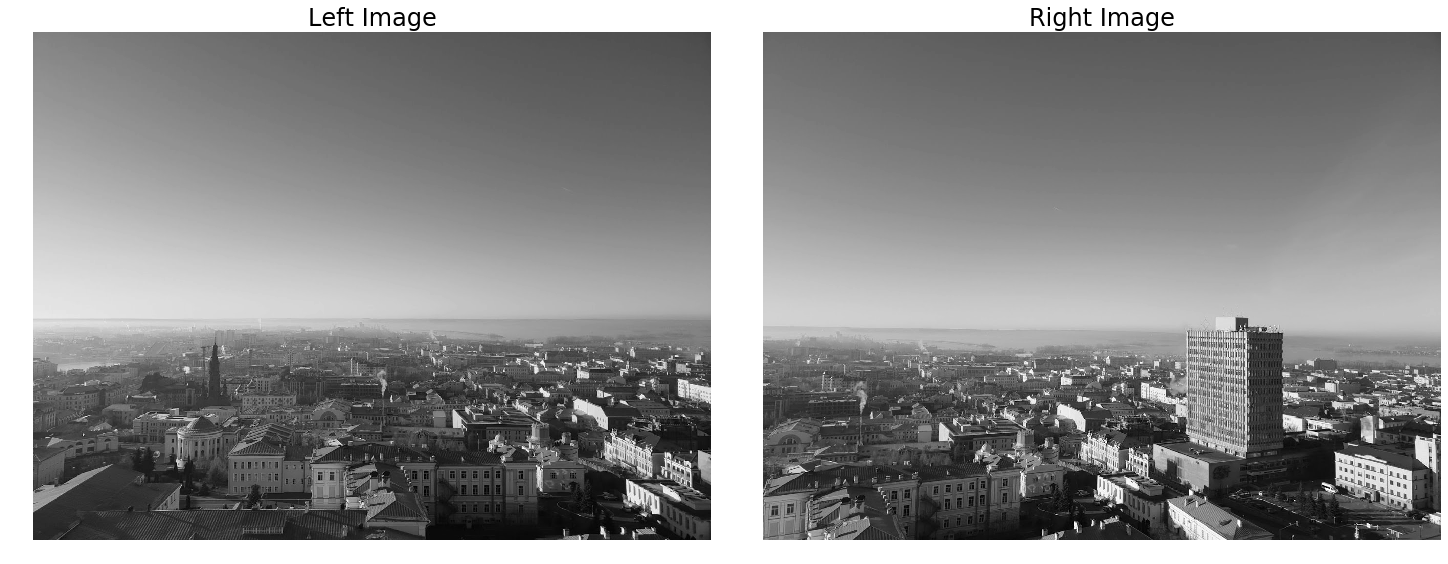

In [2]:
# load and show the images
left_img = cv.cvtColor(cv.imread('images/panorama-left.jpg'), cv.COLOR_BGR2GRAY)
right_img = cv.cvtColor(cv.imread('images/panorama-right.jpg'), cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(20,20), constrained_layout=True)

[axis.set_axis_off() for axis in axes.ravel()]

axes[0].imshow(left_img, 'gray')
axes[0].set_title('Left Image', fontsize=24)

axes[1].imshow(right_img, 'gray')
axes[1].set_title('Right Image', fontsize=24)

plt.show()

Keypoints/descriptors found (left image):  (1687, 128)
Keypoints/descriptors found (right image):  (3105, 128)


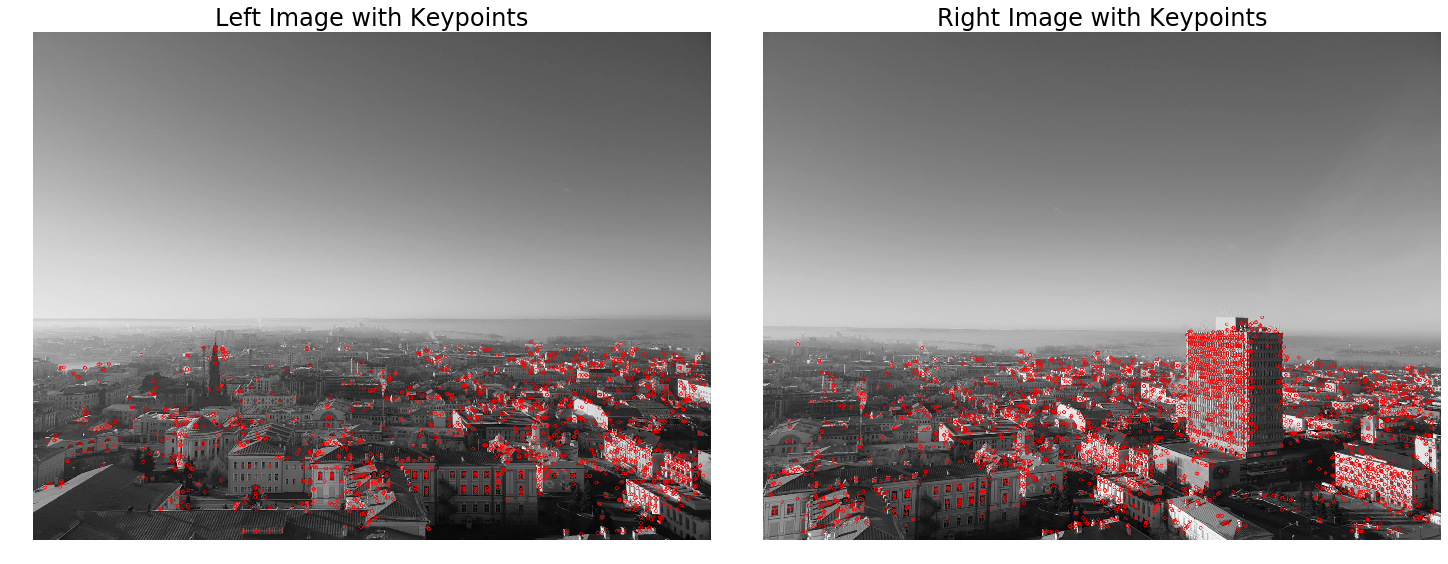

In [3]:
# extracting features using SURF
# feature is a keypoint and descriptor

surf = cv.xfeatures2d.SURF_create(hessianThreshold=1000, extended=True, upright=False)

left_keypoints, left_desc = surf.detectAndCompute(left_img, None)
right_keypoints, right_desc = surf.detectAndCompute(right_img, None)

print("Keypoints/descriptors found (left image): ", left_desc.shape)
print("Keypoints/descriptors found (right image): ", right_desc.shape)

# draw the keypoints on both images
left_img_with_keypoints = cv.drawKeypoints(left_img, left_keypoints, None, (255,0,0), 2)
right_img_with_keypoints = cv.drawKeypoints(right_img, right_keypoints, None, (255,0,0), 2)

fig, axes = plt.subplots(1, 2, figsize=(20,20), constrained_layout=True)

[axis.set_axis_off() for axis in axes.ravel()]

axes[0].imshow(left_img_with_keypoints, 'gray')
axes[0].set_title('Left Image with Keypoints', fontsize=24)

axes[1].imshow(right_img_with_keypoints, 'gray')
axes[1].set_title('Right Image with Keypoints', fontsize=24)

plt.show()

In [4]:
# match keypoints (brute-force) and filter them out by ratio (Lowe's test)

matcher = cv.BFMatcher()

raw_matches = matcher.knnMatch(left_desc, right_desc, k=2) # k-nearest neighbors

print("Keypoint matches b/w images: {}".format(len(raw_matches)))

matches = []
ratio = 0.7 # generally the ratio is in [0.7...0.8]

for m, n in raw_matches:
    if m.distance < ratio * n.distance:
        matches.append(m)
        
print("Keypoint matches b/w images (filtered): {}".format(len(matches)))

Keypoint matches b/w images: 1687
Keypoint matches b/w images (filtered): 355


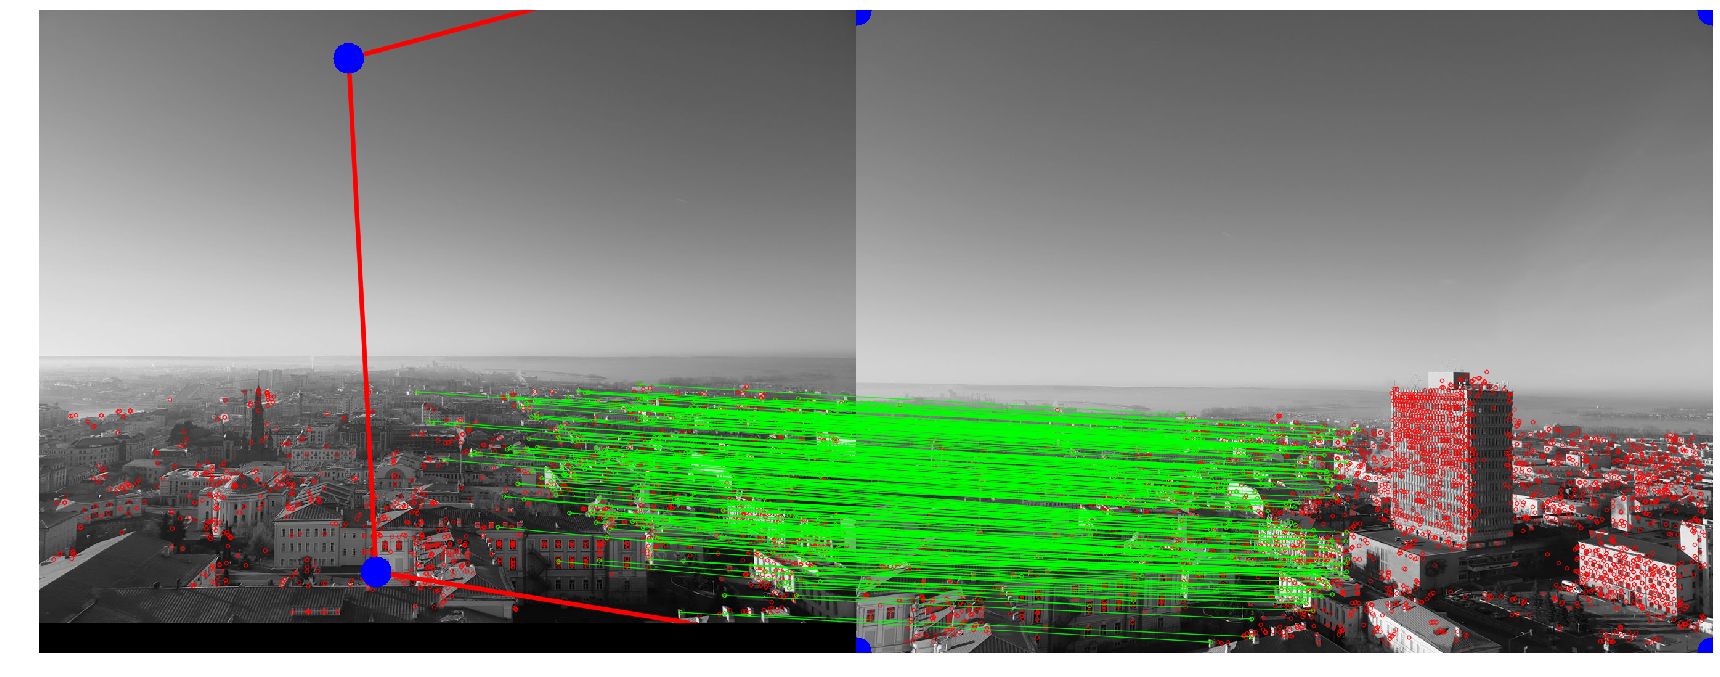

In [5]:
# estimate the homography using RANSAC (from the right to the left image)

left_points = np.float32([left_keypoints[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
right_points = np.float32([right_keypoints[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

reprojection_threshold = 5.0

M, mask = cv.findHomography(right_points, left_points, cv.RANSAC, reprojection_threshold)

mask = mask.ravel().tolist()

left_height, left_width = left_img.shape
right_height, right_width = right_img.shape

# define 4 non-colinear points on the right image (e.g. image corners)
right_img_points = np.float32([ [0, 0], [0, right_height-1], [right_width-1, right_height-1],
                              [right_width-1, 0] ]).reshape(-1,1,2)

left_img_points = cv.perspectiveTransform(right_img_points, M)

left_img_with_keypoints = cv.polylines(left_img_with_keypoints, [np.int32(left_img_points)],
                                        True, 255, 5, cv.LINE_AA)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = mask,  # draw only inliers
                   flags = 2)

for point in left_img_points:
    cv.circle(left_img_with_keypoints, (point[0][0], point[0][1]), 25, (0,0,255), -1)
    
for point in right_img_points:
    cv.circle(right_img_with_keypoints, (point[0][0], point[0][1]), 25, (0,0,255), -1)

correspondance_img = cv.drawMatches(left_img_with_keypoints, left_keypoints,
                                    right_img_with_keypoints, right_keypoints,
                                    matches, None, **draw_params)

plt.figure(figsize=(30, 30))
axes = plt.imshow(correspondance_img, 'gray'),plt.axis('off'), plt.show()

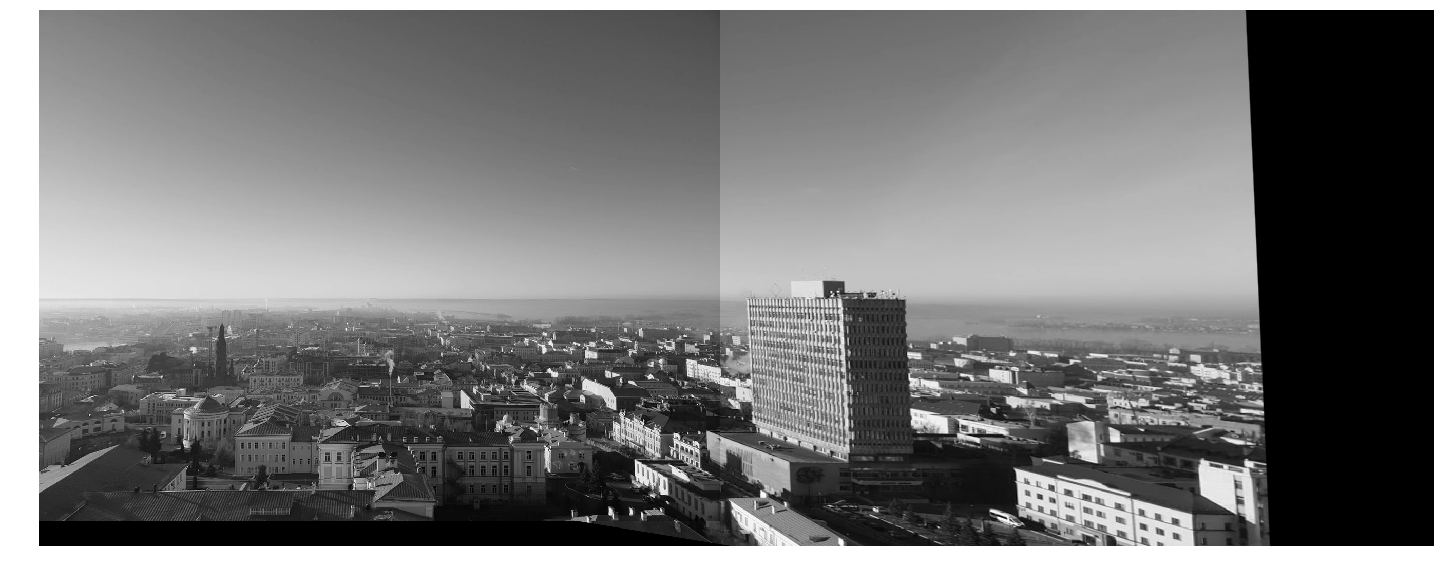

In [6]:
left_height, left_width = left_img.shape
right_height, right_width = right_img.shape

panorama_height = max(left_height, right_height)
panorama_width = left_width + right_width

panorama_img = cv.warpPerspective(right_img, M, (panorama_width, panorama_height))
panorama_img[0:left_height, 0:left_width] = left_img

plt.figure(figsize=(25, 25))
axes = plt.imshow(panorama_img, cmap='gray'), plt.axis('off'), plt.show()

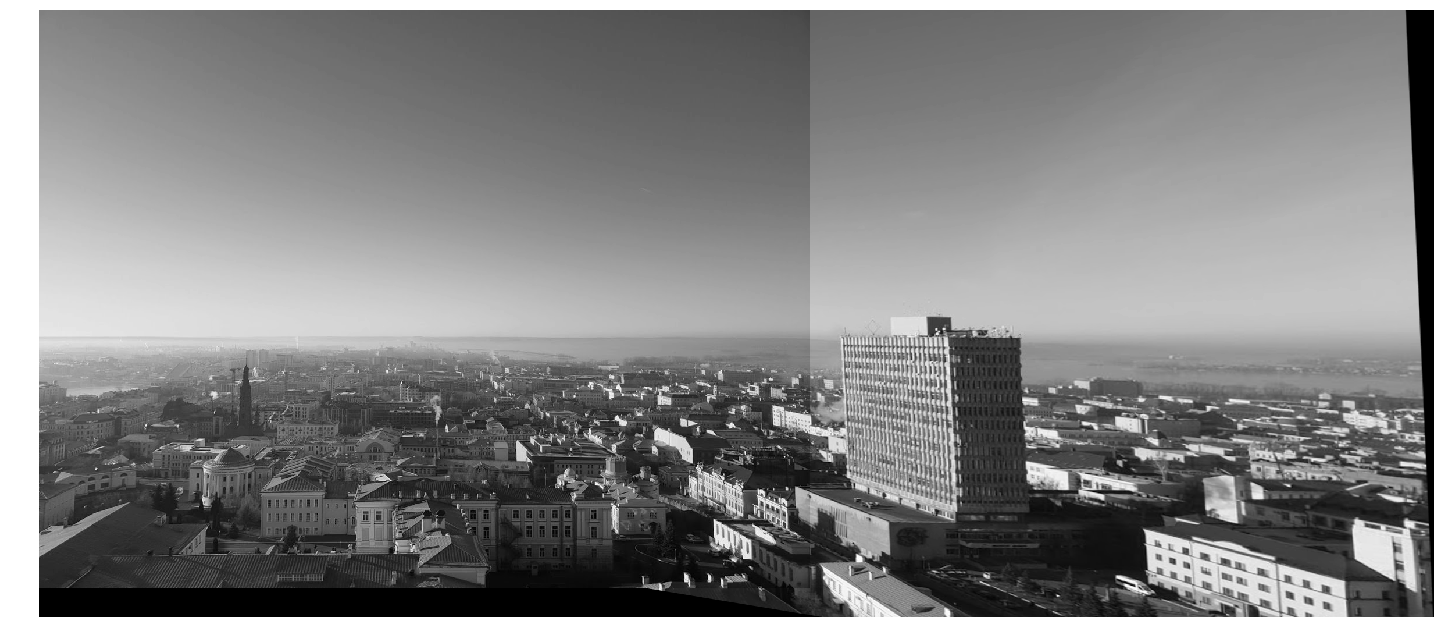

In [7]:
# https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934
def crop_image(img,tol=0):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

plt.figure(figsize=(25, 25))
axes = plt.imshow(crop_image(panorama_img), cmap='gray'), plt.axis('off'), plt.show()